In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

import onnx
import onnxruntime as ort

Currently (2022/06/11), `F.grid_sample` operation is not exportable to ONNX.

Below step registers `F.grid_sample` operation to ONNX opset. 

`F.grid_sample` export is merged to [pytorch:master](https://github.com/pytorch/pytorch/blob/master/torch/onnx/symbolic_opset16.py) and may be soon available at future stable version of PyTorch.

In [2]:
from torch.onnx import register_custom_op_symbolic
import torch.onnx.symbolic_helper as sym_help

# symbolic function makes aten::grid_sampler correspond to ONNX contrib operator
# from https://github.com/microsoft/onnxruntime/blob/master/onnxruntime/python/tools/pytorch_export_contrib_ops.py
def grid_sampler(g, input, grid, mode, padding_mode, align_corners):
    # mode
    #   'bilinear'      : onnx::Constant[value={0}]
    #   'nearest'       : onnx::Constant[value={1}]
    #   'bicubic'       : onnx::Constant[value={2}]
    # padding_mode
    #   'zeros'         : onnx::Constant[value={0}]
    #   'border'        : onnx::Constant[value={1}]
    #   'reflection'    : onnx::Constant[value={2}]
    mode = sym_help._maybe_get_const(mode, "i")
    padding_mode = sym_help._maybe_get_const(padding_mode, "i")
    mode_str = ['bilinear', 'nearest', 'bicubic'][mode]
    padding_mode_str = ['zeros', 'border', 'reflection'][padding_mode]
    align_corners = int(sym_help._maybe_get_const(align_corners, "b"))

    # From opset v13 onward, the output shape can be specified with
    # (N, C, H, W) (N, H_out, W_out, 2) => (N, C, H_out, W_out)
    # input_shape = input.type().sizes()
    # grid_shape = grid.type().sizes()
    # output_shape = input_shape[:2] + grid_shape[1:3]
    # g.op(...).setType(input.type().with_sizes(output_shape))

    return g.op("com.microsoft::GridSample", input, grid,
                mode_s=mode_str,
                padding_mode_s=padding_mode_str,
                align_corners_i=align_corners)
    
register_custom_op_symbolic('::grid_sampler', grid_sampler, opset_version=1)

In [3]:
CONFIG = './mmdetection/configs/panoptic_fpn/panoptic_fpn_r50_fpn_1x_coco.py'
IMAGE_PATH = './mmdetection/demo/demo.jpg'
CHECKPOINT = './checkpoints/panoptic_fpn_r50_fpn_1x_coco_20210821_101153-9668fd13.pth'
ONNX_MODEL_DIR = './onnx_models'
IMAGE_SIZE = (height, width) = (384, 512)

In [4]:
from mmcv import Config

from mmdet.core.export import build_model_from_cfg, preprocess_example_input
from mmdet.core.visualization import imshow_det_bboxes
from mmdet.datasets.pipelines import Compose

from functools import partial

In [5]:
def parse_normalize_cfg(test_pipeline):
    transforms = None
    for pipeline in test_pipeline:
        if 'transforms' in pipeline:
            transforms = pipeline['transforms']
            break
    assert transforms is not None, 'Failed to find `transforms`'
    norm_config_li = [_ for _ in transforms if _['type'] == 'Normalize']
    assert len(norm_config_li) == 1, '`norm_config` should only have one'
    norm_config = norm_config_li[0]
    return norm_config


def show_panoptic_seg(
    img: str,
    bboxes: np.ndarray,  # (n, 4or5), n = num bboxes
    labels: np.ndarray,  # (n)
    masks: np.ndarray,   # (n, h, w)
    segment: np.ndarray, # (h, w)
    class_names: list,
    score_thr: float,
    out_file: str = None,
    show: bool = True) -> None:
    visualized = imshow_det_bboxes(
        img=img,
        bboxes=bboxes,
        labels=labels,
        segms=masks,
        class_names=class_names,
        score_thr=0.5,
        out_file=None,
        show=False)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)

    ax1.set_title('instance segmentation')
    ax1.axis('off')
    ax1.imshow(visualized[:,:,::-1]) # BGR->RGB

    ax2.set_title('semantic segmentation')
    ax2.axis('off')
    ax2.imshow(segment)
    
    if out_file:
        plt.savefig(out_file, bbox_inches='tight', pad_inches=0)
    if show:
        plt.show()
    plt.close()

In [6]:
cfg = Config.fromfile(CONFIG)
input_shape = (1, 3, height, width)

normalize_cfg = parse_normalize_cfg(cfg.test_pipeline)

input_config = {
    'input_shape': input_shape,
    'input_path': IMAGE_PATH,
    'normalize_cfg': normalize_cfg
}
    
one_img, one_meta = preprocess_example_input(input_config)
img_list, img_meta_list = [one_img], [[one_meta]]

In [7]:
model = build_model_from_cfg(CONFIG, CHECKPOINT)

/root/mmdetection/mmdet/models/losses/cross_entropy_loss.py:239: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


load checkpoint from local path: ./checkpoints/panoptic_fpn_r50_fpn_1x_coco_20210821_101153-9668fd13.pth


In [8]:
with torch.no_grad():
    outputs = model.onnx_export(img_list[0], img_meta_list[0])

for o in outputs:
    print(o.shape)

/root/mmdetection/mmdet/core/bbox/coder/delta_xywh_bbox_coder.py:102: UserWarning: DeprecationWarning: onnx_delta2bbox is deprecated in the case of batch decoding and non-ONNX, please use “delta2bbox” instead. In order to improve the decoding speed, the batch function will no longer be supported. 
  warnings.warn(


torch.Size([1, 100, 5])
torch.Size([1, 100])
torch.Size([1, 100, 384, 512])
torch.Size([1, 54, 384, 512])


In [9]:
img_list[0].shape

torch.Size([1, 3, 384, 512])

In [10]:
input_name = 'input'
output_names = ['dets', 'labels', 'masks', 'sem_seg']
dynamic_axes = {
    input_name: {0: 'batch', 2: 'height', 3: 'width'},
    'dets': {0: 'batch'},
    'labels': {0: 'batch'},
    'masks': {0: 'batch', 2: 'height', 3: 'width'},
    'sem_seg': {0: 'batch', 2: 'height', 3: 'width'}
}

origin_forward = model.forward
model.forward = partial(
    model.forward,
    img_metas=img_meta_list,
    return_loss=False
)

onnx_file = os.path.basename(CHECKPOINT).replace('pth', 'onnx')
onnx_model_path = f'{ONNX_MODEL_DIR}/{onnx_file}'

torch.onnx.export(
    model,
    img_list,
    onnx_model_path,
    input_names=[input_name],
    output_names=output_names,
    export_params=True,
    keep_initializers_as_inputs=False,
    do_constant_folding=True,
    verbose=False,
    opset_version=11,
    dynamic_axes=dynamic_axes
)
print('Successfully export the PyTorch model to ONNX format')

/root/mmdetection/mmdet/models/dense_heads/base_dense_head.py:415: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nms_pre_tensor = torch.tensor(
/root/mmdetection/mmdet/models/dense_heads/base_dense_head.py:436: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert cls_score.size()[-2:] == bbox_pred.size()[-2:]
/root/mmdetection/mmdet/core/export/onnx_helper.py:63: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this valu

Successfully export the PyTorch model to ONNX format


In [11]:
sess = ort.InferenceSession(onnx_model_path)

In [12]:
for i in sess.get_inputs():
    print(i.name, i.shape)

print('---input/output---')

for o in sess.get_outputs():
    print(o.name, o.shape)

input ['batch', 3, 'height', 'width']
---input/output---
dets ['batch', 'Concatdets_dim_1', 'Concatdets_dim_2']
labels ['batch', 'Reshapelabels_dim_1']
masks ['batch', 'Reshapemasks_dim_1', 'height', 'width']
sem_seg ['batch', 'Resizesem_seg_dim_1', 'height', 'width']


In [13]:
onnx_results = sess.run(None, {'input': img_list[0].detach().numpy()})

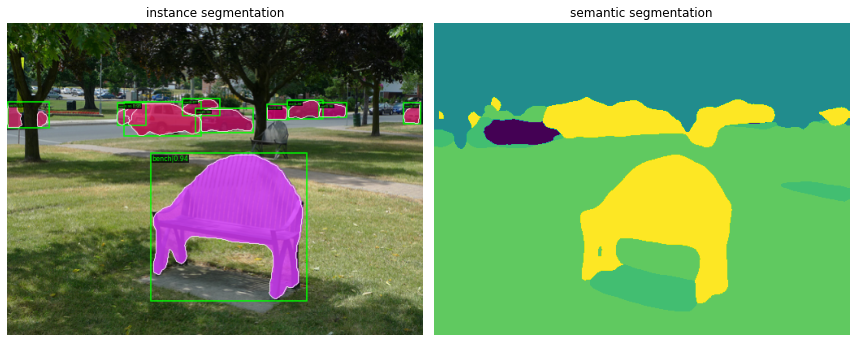

In [14]:
dets, labels, masks, sem_seg = onnx_results
segment = np.argmax(sem_seg[0], axis=0)

show_panoptic_seg(
    img=one_meta['show_img'],
    bboxes=dets[0],
    labels=labels[0],
    masks=masks[0],
    segment=segment,
    class_names=model.CLASSES,
    score_thr=0.5,
    out_file=f'./show-ort-panoptic.png',
    show=True
)